In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

## Hybrid models
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.deterministic import DeterministicProcess

In [207]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from window_ops.rolling  import rolling_mean, rolling_max, rolling_min
from mlforecast import MLForecast
import lightgbm as lgb
from numba import njit
# import optuna
SEED = 24

# Model base

### Read data

In [3]:
data_raw = pd.read_csv("Verbr_2008_2021_sanitarisiert.txt", sep='\t')
data_raw = data_raw.set_index("MatNr_n")
data_raw

,M200801,M200802,M200803,M200804,M200805,M200806,M200807,M200808,M200809,M200810,...,M202103,M202104,M202105,M202106,M202107,M202108,M202109,M202110,M202111,M202112
MatNr_n,,,,,,,,,,,,,,,,,,,,,
103379653791,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104080986274,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105025501059,0,0,0,0,0,7,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
106130007753,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106939853290,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7653154999930,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7653761044143,0,0,0,0,0,0,1,0,5,0,...,4,0,0,0,4,2,4,4,0,4
7654080459855,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
df

,M200801,M200802,M200803,M200804,M200805,M200806,M200807,M200808,M200809,M200810,...,M202103,M202104,M202105,M202106,M202107,M202108,M202109,M202110,M202111,M202112
MatNr_n,,,,,,,,,,,,,,,,,,,,,
103379653791,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104080986274,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105025501059,0,0,0,0,0,7,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
106130007753,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106939853290,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7653154999930,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7653761044143,0,0,0,0,0,0,1,0,5,0,...,4,0,0,0,4,2,4,4,0,4
7654080459855,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [167]:
sr_mean = df.mean(axis=1)

In [168]:
sr_mean

MatNr_n
103379653791     0.291667
104080986274     0.000000
105025501059     0.309524
106130007753     0.017857
106939853290     0.005952
                   ...   
7653154999930    0.023810
7653761044143    4.988095
7654080459855    0.011905
7655055223997    1.589286
7656278055228    0.065476
Length: 150810, dtype: float64

In [169]:
print("numbers of mean in [1000 -> ]:",sr_mean[sr_mean > 1000].shape[0])
print("numbers of mean in [1000 -> 100]:",sr_mean[(sr_mean < 1000) & (sr_mean > 100)].shape[0])
print("numbers of mean in [10 -> 100]:",sr_mean[(sr_mean < 100) & (sr_mean > 10)].shape[0])
print("numbers of mean in [1 -> 10]:",sr_mean[(sr_mean < 10) & (sr_mean > 1)].shape[0])
print("numbers of mean in [0 -> 1]:",sr_mean[(sr_mean < 1)].shape[0])

numbers of mean in [1000 -> ]: 46
numbers of mean in [1000 -> 100]: 562
numbers of mean in [10 -> 100]: 4738
numbers of mean in [1 -> 10]: 19867
numbers of mean in [0 -> 1]: 125538


### Split training and testing

In [4]:
%%time
df = data_raw.copy() 
cols_train = df.columns[:-12]
cols_test = df.columns[-12:]
df_train = df[cols_train]
df_test = df[cols_test]

Wall time: 439 ms


In [5]:
df_train

,M200801,M200802,M200803,M200804,M200805,M200806,M200807,M200808,M200809,M200810,...,M202003,M202004,M202005,M202006,M202007,M202008,M202009,M202010,M202011,M202012
MatNr_n,,,,,,,,,,,,,,,,,,,,,
103379653791,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104080986274,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105025501059,0,0,0,0,0,7,0,0,0,0,...,2,0,5,0,0,0,0,0,0,0
106130007753,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106939853290,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7653154999930,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7653761044143,0,0,0,0,0,0,1,0,5,0,...,2,0,0,0,0,2,2,8,2,0
7654080459855,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
150810*156

23526360

### Data Processing

In [7]:
df_train.reset_index(inplace = True)
df_test.reset_index(inplace=True)

df_train = df_train.melt(id_vars = "MatNr_n", var_name='date',value_name="demand")
df_test = df_test.melt(id_vars = "MatNr_n", var_name='date',value_name="demand")

In [8]:
%%time
## processing date
df_train['date'] = df_train['date'].apply(lambda x: datetime.strptime(x,'M%Y%m').date())
df_test['date'] = df_test['date'].apply(lambda x: datetime.strptime(x,'M%Y%m').date())
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

Wall time: 7min 32s


In [9]:
%%time
df_train = df_train.sort_values(by=['MatNr_n','date']).reset_index(drop=True)
df_test = df_test.sort_values(by=['MatNr_n','date']).reset_index(drop=True)

Wall time: 19.7 s


In [10]:
df_train.head()

,MatNr_n,date,demand
0,139437620,2008-01-01,0
1,139437620,2008-02-01,0
2,139437620,2008-03-01,0
3,139437620,2008-04-01,0
4,139437620,2008-05-01,0


### Create and training base model

In [30]:
@njit
def diff(x, lag):
    x2 = np.full_like(x, np.nan)
    for i in range(lag, len(x)):
        x2[i] = x[i] - x[i-lag]
    return x2

In [31]:
models  = [RandomForestRegressor(random_state=0, n_estimators=100)]
# ExtraTreesRegressor(random_state=0, n_estimators=100)

In [32]:
model = MLForecast(models=models,
                   freq='m',
                   lags=[1,3,6],
                   lag_transforms={
                       1: [(rolling_mean, 3), (rolling_mean, 6), (diff, 1), (diff, 3), (diff, 6)],
                   },
                   num_threads=6)

In [85]:
%%time
model.fit(df_train, id_col='MatNr_n', time_col='date', target_col='demand', static_features=[])

Wall time: 3h 11min 55s


MLForecast(models=[RandomForestRegressor], freq=<MonthEnd>, lag_features=['lag1', 'lag3', 'lag6', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size6', 'diff_lag1_lag1', 'diff_lag1_lag3', 'diff_lag1_lag6'], date_features=[], num_threads=6)

In [87]:
pred_rfr = model.predict(horizon=12, dynamic_dfs=[df_test[['MatNr_n', 'date']]])

In [89]:
pred_rfr.date = pred_rfr.date.values +  pd.Timedelta(days=1)
pred_rfr = pred_rfr.merge(df_test[['MatNr_n', 'date', 'demand']], on=['MatNr_n', 'date'], how='left')

In [94]:
pred_rfr['round_rfr'] = np.round(pred_rfr['RandomForestRegressor'])

In [95]:
pred_rfr

,MatNr_n,date,RandomForestRegressor,demand,round_rfr
0,139437620,2021-01-01,0.354690,0,0.0
1,139437620,2021-02-01,0.354690,0,0.0
2,139437620,2021-03-01,0.324427,0,0.0
3,139437620,2021-04-01,0.363171,0,0.0
4,139437620,2021-05-01,0.369665,0,0.0
...,...,...,...,...,...
1809715,9999995732367,2021-08-01,0.351992,0,0.0
1809716,9999995732367,2021-09-01,0.351992,0,0.0
1809717,9999995732367,2021-10-01,0.351992,0,0.0
1809718,9999995732367,2021-11-01,0.351992,0,0.0


### Evalutate

In [96]:
print("before round: ", MAPE(pred_rfr['demand'], pred_rfr['RandomForestRegressor']))
print("after round: ", MAPE(pred_rfr['demand'], pred_rfr['round_rfr']))

before round:  6130540835534759.0
after round:  5006351276641944.0


Int64Index([1086319491074, 1225094293108,  798511945987, 1099930063068,
             830786735112, 1018854277039, 1009770854891, 1416691645478,
            1159808429837, 2072313828998, 1813773580904, 1650142705341,
            3089163625062, 3214222508547, 1973305780209, 4224187353278,
            3159587753443, 3158531461320, 4844245902983, 5389807333928,
            4223824677631, 4735640984583, 4279980603847, 5787259092901,
            5447948155405, 6764026631562, 4975366280983, 7883591876108,
            5836836063138, 6364232866334, 7182720699545, 5106756966055,
            5095832458824, 6612234412242, 9013070639949, 8916880605709,
            8043155656563, 8089061152877, 6715779655191, 9720203047129,
            8839178973521, 9738189922647, 8771176544670, 8785282882967,
            8740642816580, 8657054261640],
           dtype='int64', name='MatNr_n')

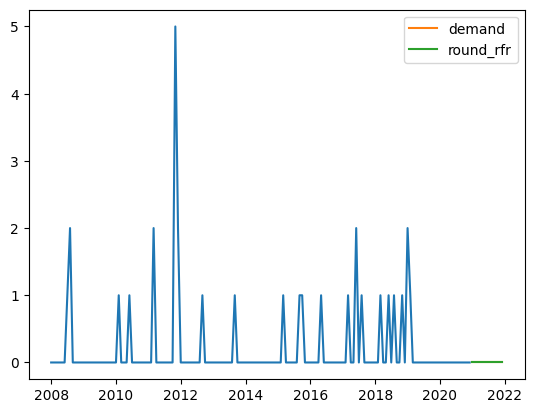

In [206]:
# index = np.random.choice(df_test.MatNr_n.unique())
index = np.random.choice(sr_mean[(sr_mean < 1)].index)

plt.plot(df_train[df_train['MatNr_n'] == index].date, df_train[df_train['MatNr_n'] == index].demand);
plt.plot(df_test[df_test['MatNr_n'] == index].date,df_test[df_test['MatNr_n'] == index].demand, label = "demand");
plt.plot(pred_rfr[pred_rfr['MatNr_n'] == index].date,pred_rfr[pred_rfr['MatNr_n'] == index].round_rfr, label = "round_rfr");
plt.legend()

## HistGradientBoostingRegressor

In [39]:
models_hgb = [HistGradientBoostingRegressor(random_state=0)]

In [41]:
base_hgb =  MLForecast(models=models_hgb,
                   freq='m',
                   lags=[1,3,6],
                   lag_transforms={
                       1: [(rolling_mean, 3), (rolling_mean, 6), (diff, 1), (diff, 3), (diff, 6)],
                   },
                   num_threads=6)

In [42]:
%%time
base_hgb.fit(df_train, id_col='MatNr_n', time_col='date', target_col='demand', static_features=[])

Wall time: 2min 54s


MLForecast(models=[HistGradientBoostingRegressor], freq=<MonthEnd>, lag_features=['lag1', 'lag3', 'lag6', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size6', 'diff_lag1_lag1', 'diff_lag1_lag3', 'diff_lag1_lag6'], date_features=[], num_threads=6)

In [46]:
pred_base_hgb = base_hgb.predict(horizon=12, dynamic_dfs=[df_test[['MatNr_n', 'date']]])
pred_base_hgb.date =pred_base_hgb.date.values +  pd.Timedelta(days=1)
pred_base_hgb = pred_base_hgb.merge(df_test[['MatNr_n', 'date', 'demand']], on=['MatNr_n', 'date'], how='left')

In [47]:
pred_base_hgb

,MatNr_n,date,HistGradientBoostingRegressor,demand
0,139437620,2021-01-01,0.408067,0
1,139437620,2021-02-01,0.443829,0
2,139437620,2021-03-01,0.443829,0
3,139437620,2021-04-01,0.499485,0
4,139437620,2021-05-01,0.499485,0
...,...,...,...,...
1809715,9999995732367,2021-08-01,0.824963,0
1809716,9999995732367,2021-09-01,0.824963,0
1809717,9999995732367,2021-10-01,0.824963,0
1809718,9999995732367,2021-11-01,0.824963,0


In [52]:
MAPE(pred_base_hgb['demand'], pred_base_hgb['HistGradientBoostingRegressor'])

7739493211027506.0

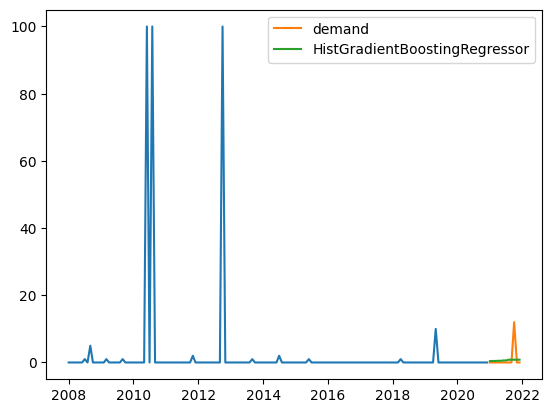

In [84]:
index = np.random.choice(df_test.MatNr_n.unique())
plt.plot(df_train[df_train['MatNr_n'] == index].date, df_train[df_train['MatNr_n'] == index].demand);
plt.plot(df_test[df_test['MatNr_n'] == index].date,df_test[df_test['MatNr_n'] == index].demand, label = "demand");
plt.plot(pred_base_hgb[pred_base_hgb['MatNr_n'] == index].date,pred_base_hgb[pred_base_hgb['MatNr_n'] == index].HistGradientBoostingRegressor, label = "HistGradientBoostingRegressor");
plt.legend()

In [70]:
def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1e-1)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    
    lags = trial.suggest_int('lags', 14, 56, step=7) # step means we only try multiples of 7 starting from 14
    
    
    
    models_hgb = [HistGradientBoostingRegressor(random_state=0)]
    
    
    models = [XGBRegressor(random_state=0, n_estimators=500,    learning_rate=learning_rate, max_depth=max_depth,
                           min_child_weight=min_child_weight, subsample=subsample, colsample_bytree=colsample_bytree)]

    model = MLForecast(models=models,
                    freq='D',
                    lags=[1,7, lags],
                    lag_transforms={
                       1: [(rolling_mean, 7), (rolling_max, 7), (rolling_min, 7)],
                   }, # removing this is better
                    date_features=['dayofweek', 'month'],
                    num_threads=6)


    model.fit(train, id_col='unique_id', time_col='ds', target_col='y', static_features=[])

    p = model.predict(horizon=h)
    p = p.merge(valid[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'], how='left')

    error = mean_absolute_percentage_error(p['y'], p['XGBRegressor'])
    
    return error

## Training with MLForecast LGBMRegressor

In [37]:
model_LGBM = lgb.LGBMRegressor(random_state=0)
model_lgbm = MLForecast(models=model_LGBM,
                   freq='m',
                   lags=[1,3,6],
                   lag_transforms={
                       1: [(rolling_mean, 3), (rolling_mean, 6), (diff, 1), (diff, 3), (diff, 6)],
                   },
                   date_features=['month'],
                   num_threads=6)

In [152]:
%%time
model_lgbm.fit(df_train, id_col='MatNr_n', time_col='date', target_col='demand', static_features=[])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.907220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2035
[LightGBM] [Info] Number of data points in the train set: 22470690, number of used features: 9
[LightGBM] [Info] Start training from score 2.921810
Wall time: 1min 29s


MLForecast(models=[LGBMRegressor], freq=<MonthEnd>, lag_features=['lag1', 'lag3', 'lag6', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size6', 'diff_lag1_lag1', 'diff_lag1_lag3', 'diff_lag1_lag6'], date_features=['month'], num_threads=6)

In [238]:
model_lgbm.preprocess(df_train, id_col='MatNr_n', time_col='date', target_col='demand', static_features=[])

MemoryError: Unable to allocate 686. MiB for an array with shape (8, 22470690) and data type float32

In [153]:
pred_lgbm = model_lgbm.predict(horizon=12, dynamic_dfs=[df_test[['MatNr_n', 'date']]])
pred_lgbm.date =pred_lgbm.date.values +  pd.Timedelta(days=1)
pred_lgbm = pred_lgbm.merge(df_test[['MatNr_n', 'date', 'demand']], on=['MatNr_n', 'date'], how='left')

In [156]:
pred_lgbm['round_lgbm'] = np.round(pred_lgbm['LGBMRegressor'])

In [157]:
pred_lgbm

,MatNr_n,date,LGBMRegressor,demand,round_lgbm
0,139437620,2021-01-01,0.51669,0,1.0
1,139437620,2021-02-01,0.51669,0,1.0
2,139437620,2021-03-01,0.51669,0,1.0
3,139437620,2021-04-01,0.51669,0,1.0
4,139437620,2021-05-01,0.51669,0,1.0
...,...,...,...,...,...
1809715,9999995732367,2021-08-01,0.51669,0,1.0
1809716,9999995732367,2021-09-01,0.51669,0,1.0
1809717,9999995732367,2021-10-01,0.51669,0,1.0
1809718,9999995732367,2021-11-01,0.51669,0,1.0


In [158]:
print("before round: ", MAPE(pred_lgbm['demand'], pred_lgbm['LGBMRegressor']))
print("after round: ", MAPE(pred_lgbm['demand'], pred_lgbm['round_lgbm']))

before round:  5242388575766065.0
after round:  7012880951480294.0


## base LGBMRegressor

In [ ]:
df_train, id_col='MatNr_n', time_col='date', target_col='demand', static_features=[]

In [217]:
np.subtract(df_train.columns.values, ['demand'])

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [227]:
df_train

,MatNr_n,date,demand
0,139437620,2008-01-01,0
1,139437620,2008-02-01,0
2,139437620,2008-03-01,0
3,139437620,2008-04-01,0
4,139437620,2008-05-01,0
...,...,...,...
23526355,9999995732367,2020-08-01,0
23526356,9999995732367,2020-09-01,0
23526357,9999995732367,2020-10-01,0
23526358,9999995732367,2020-11-01,0


array([0, 1], dtype=int64)

In [234]:
X_train = df_train.iloc[:,np.where(df_train.columns.values != 'demand')[0]]
y_train = df_train.loc[:, ['demand']]

,MatNr_n,date
0,139437620,2008-01-01
1,139437620,2008-02-01
2,139437620,2008-03-01
3,139437620,2008-04-01
4,139437620,2008-05-01
...,...,...
23526355,9999995732367,2020-08-01
23526356,9999995732367,2020-09-01
23526357,9999995732367,2020-10-01
23526358,9999995732367,2020-11-01


In [236]:
model_lgb = lgb.LGBMRegressor(random_state=SEED)

In [237]:
model_lgb.fit(X_train, y_train)

ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: date: datetime64[ns]

## Tune LGBMRegressor Hyperparameters with optuna

In [ ]:
def objective(trial, data, selected_features, target_col='health_condition'):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000, 7000, 15000, 20000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 20, 5000, step=20),
        "max_depth": trial.suggest_int("max_depth", 10, 50),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "max_bin": trial.suggest_int("max_bin", 200, 300),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
        "n_jobs": 10,
        "random_state": SEED
    }   
    
    reg_model = lgb.LGBMRegressor(**param_grid)
    reg_model.fit(X_train, y_train)
    
    
    return reg_model.score(X_test, y_test)